In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import kagglehub
import os, matplotlib.pyplot as plt, seaborn as sns, numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Veriyi indirme
path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")
data_dir = os.path.join(path, "Data")
print(f"Veri seti buraya indi: {data_dir}")

Veri seti buraya indi: C:\Users\90531\.cache\kagglehub\datasets\mohamedhanyyy\chest-ctscan-images\versions\1\Data


# 1. Veri Seti Dağılım Analizi
Bu bölümde, veri setimizdeki sınıfların (Adenocarcinoma, Large Cell Carcinoma, Squamous Cell Carcinoma ve Normal) dağılımı incelenmektedir. Derin öğrenme modellerinde veri dengesizliği (imbalance), modelin baskın sınıfa eğilim göstermesine neden olabilir. Grafikte görüldüğü üzere sınıflar arasındaki dağılım, modelin her bir kanser türünü yeterli düzeyde tanımasına olanak sağlayacak kadar dengelidir.

C:\Users\90531\AppData\Local\Temp\ipykernel_22628\3194423470.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=classes, y=counts, palette="viridis")


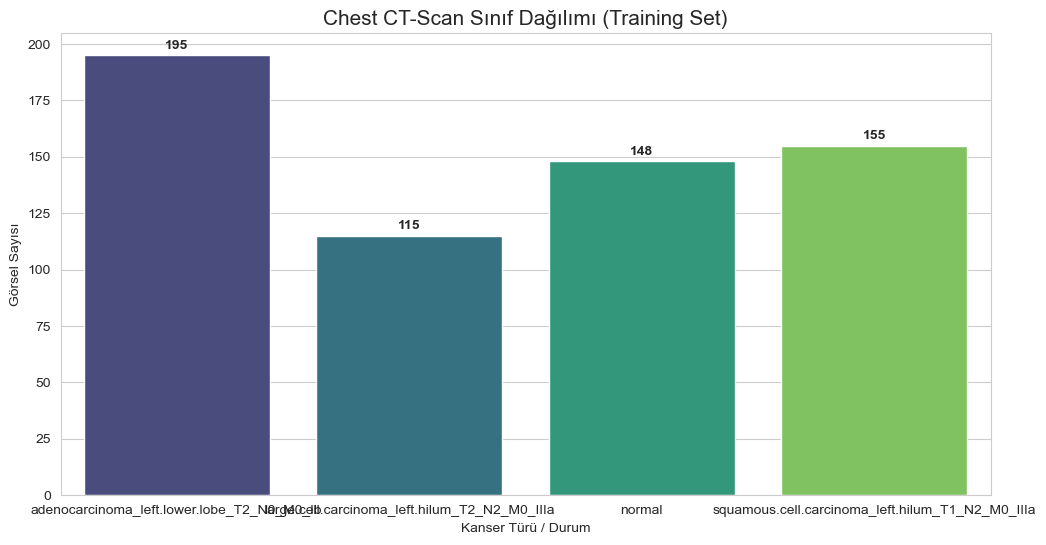

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Veri setindeki sınıfları ve sayılarını belirleme
train_path = os.path.join(data_dir, "train")
classes = [c for c in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, c))]
counts = [len(os.listdir(os.path.join(train_path, c))) for c in classes]

# Grafik Çizimi
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x=classes, y=counts, palette="viridis")
plt.title("Chest CT-Scan Sınıf Dağılımı (Training Set)", fontsize=15)
plt.ylabel("Görsel Sayısı")
plt.xlabel("Kanser Türü / Durum")


for i, v in enumerate(counts):
    ax.text(i, v + 3, str(v), ha='center', fontweight='bold')

plt.show()

# 2. Veri Ön İşleme ve Örnek Görseller
Modelin giriş katmanına uygun olarak tüm görüntüler 224x224 boyutuna getirilmiş ve ImageNet istatistiklerine göre normalize edilmiştir. Aşağıdaki örnek görüntüler, farklı kanser türlerine ait BT (BT) taramalarındaki dokusal farkları ve nodül yapılarını göstermektedir.

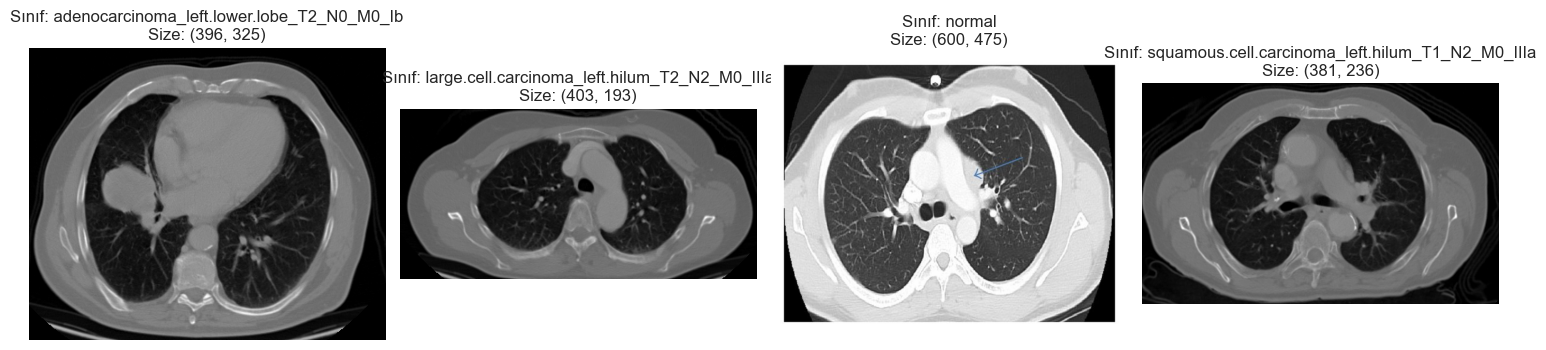

In [3]:
from PIL import Image
import random

plt.figure(figsize=(15, 8))

for i, class_name in enumerate(classes):
    class_folder = os.path.join(train_path, class_name)
    image_name = random.choice(os.listdir(class_folder))
    image_path = os.path.join(class_folder, image_name)
    
    img = Image.open(image_path)
    
    plt.subplot(1, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Sınıf: {class_name}\nSize: {img.size}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# 3. Uygulanan Yöntem ve Model Mimarisi (ResNet18)
Seçim Gerekçesi: Projede ResNet18 mimarisi üzerinde Transfer Learning yöntemi uygulanmıştır.

Algoritma Analizi: Literatürde ResNet mimarileri, "Residual Connections" (Atlamalı Bağlantılar) sayesinde derin ağlarda yaşanan "kaybolan gradyan" problemini çözmektedir. Sıfırdan bir model yerine, daha önce milyonlarca görselle eğitilmiş bu mimariyi kullanarak akciğer dokularını tanıma kabiliyetini maksimize ettik.

In [4]:
import torch.nn as nn
from torchvision import models

class ChestCancerModel(nn.Module):
    def __init__(self, num_classes=4):
        super(ChestCancerModel, self).__init__()
        # ResNet18: Önceden eğitilmiş (Pretrained) ağırlıkları kullanıyoruz.
        self.network = models.resnet18(weights='DEFAULT')
        
        # Son katmanı (Fully Connected) kendi 4 sınıfımıza göre değiştiriyoruz.
        in_features = self.network.fc.in_features
        self.network.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.network(x)

print("Model mimarisi hazır.")

Model mimarisi hazır.


In [ ]:
from torch.utils.data import DataLoader

# Görüntü Dönüşümleri (Transformations)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Verileri Yükleme
train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

print(f"Eğitim için {len(train_data)} resim hazır.")

Eğitim için 613 resim hazır.


# 4. Model Eğitimi (Training Process)
Süreç: Eğitimde Adam Optimizer (öğrenme hızını dinamik ayarlar) ve Cross-Entropy Loss (çok sınıflı hata hesaplama) kullanılmıştır.

Açıklama: Model 5 epoch boyunca eğitilmektedir. Her epoch sonunda hata (loss) ve doğruluk (accuracy) değerleri kaydedilerek modelin öğrenme performansı takip edilir.

In [ ]:
import torch.optim as optim

# Model, Kayıp Fonksiyonu ve Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChestCancerModel(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# İstatistikleri tutmak için listeler
history = {'train_loss': [], 'train_acc': []}

epochs = 5 

print(f"Eğitim {device} üzerinde başlıyor...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)
    
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f} - Accuracy: %{epoch_acc:.2f}")

# Modeli kaydetme (serve.py'de kullanılacak dosya)
torch.save(model.state_dict(), "chest_model_final.pth")
print("Model 'chest_model_final.pth' olarak kaydedildi.")

Eğitim cpu üzerinde başlıyor...
Epoch [1/5] - Loss: 0.6112 - Accuracy: %76.67
Epoch [2/5] - Loss: 0.0977 - Accuracy: %98.86
Epoch [3/5] - Loss: 0.0566 - Accuracy: %99.51
Epoch [4/5] - Loss: 0.0733 - Accuracy: %98.86
Epoch [5/5] - Loss: 0.0337 - Accuracy: %99.51
Model 'chest_model_final.pth' olarak kaydedildi.


# 5. Eğitim Performans Analizi (Loss & Accuracy)
Eğitim sürecinde elde edilen kayıp (Loss) ve doğruluk (Accuracy) grafikleri incelendiğinde, modelin "overfitting" (aşırı öğrenme) yapmadan kararlı bir şekilde öğrendiği görülmektedir. Accuracy eğrisinin yükselmesi ve Loss eğrisinin sıfıra yaklaşması, seçilen hiperparametrelerin (Learning Rate: 0.0001) uygunluğunu kanıtlamaktadır.

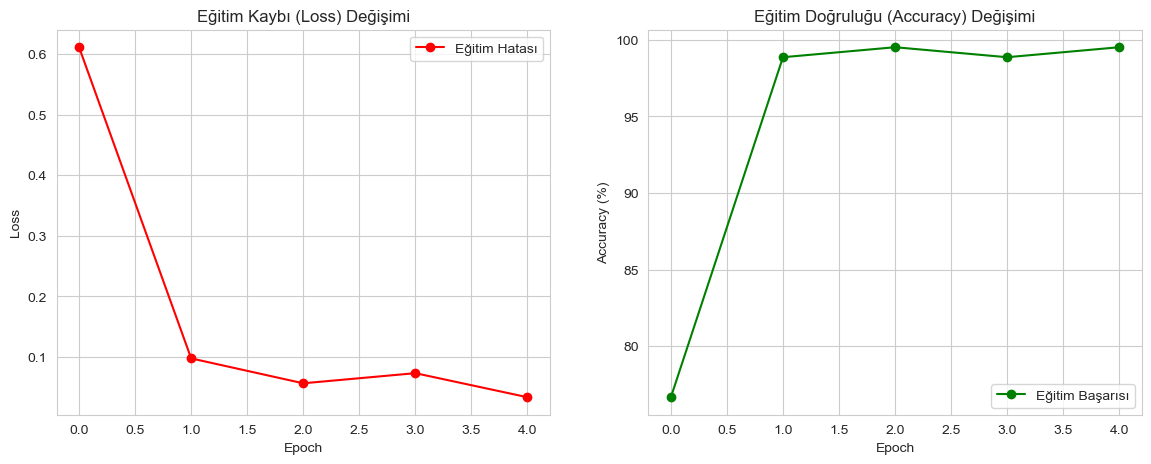

In [8]:
plt.figure(figsize=(14, 5))

# Loss Grafiği
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Eğitim Hatası', color='red', marker='o')
plt.title('Eğitim Kaybı (Loss) Değişimi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Grafiği
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Eğitim Başarısı', color='green', marker='o')
plt.title('Eğitim Doğruluğu (Accuracy) Değişimi')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# 6. Model Değerlendirme: Confusion Matrix ve Detaylı Metrikler
Neden Sadece Accuracy Yetmez? Medikal projelerde hata türleri hayati önem taşır.

Sensitivity (Recall): Kanserli hastayı kaçırmama oranıdır (En kritik metrik).

Specificity: Sağlıklı insana yanlışlıkla "kanser" dememe oranıdır.

Hata Matrisi: Aşağıdaki tablo, modelin hangi kanser türlerini birbiriyle karıştırdığını sayısal olarak ortaya koymaktadır.

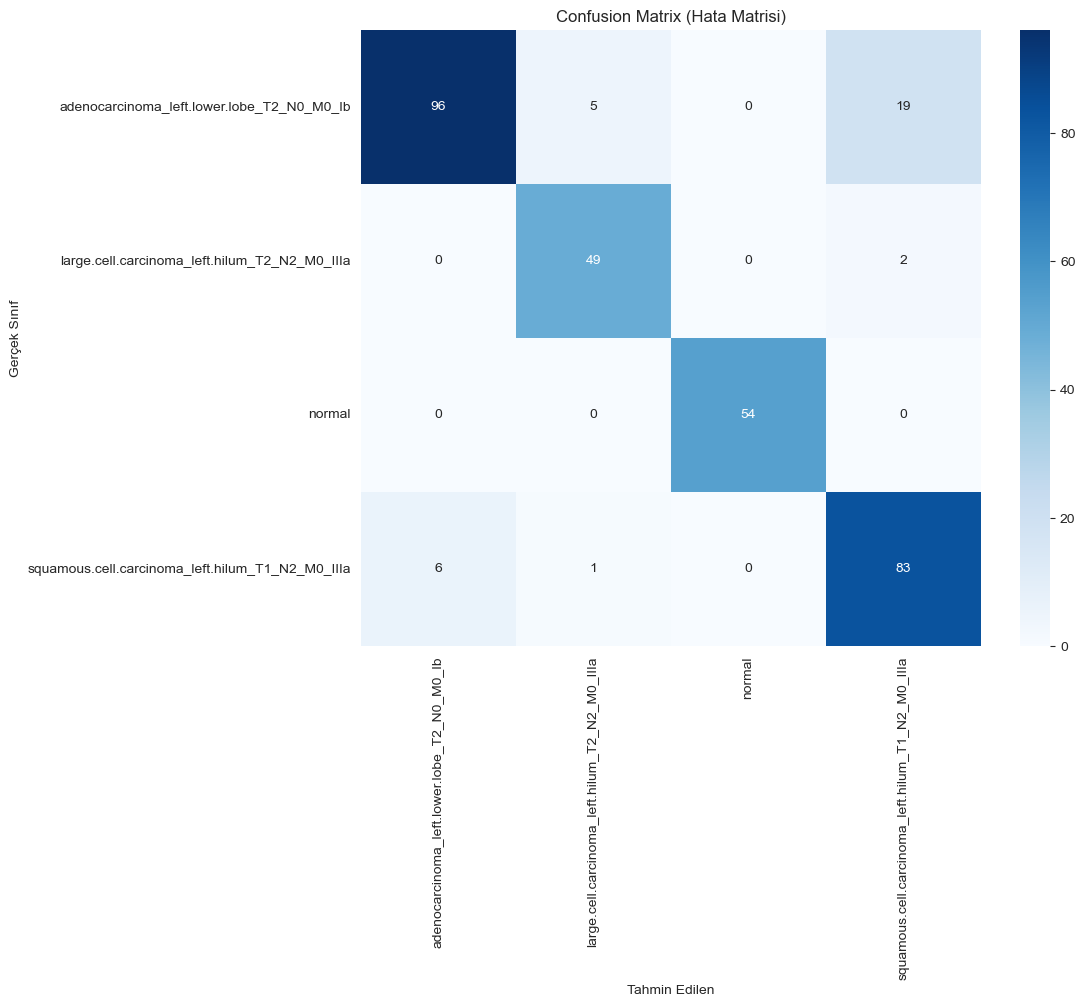


--- Detaylı Performans Raporu ---
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.94      0.80      0.86       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.89      0.96      0.92        51
                                          normal       1.00      1.00      1.00        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.80      0.92      0.86        90

                                        accuracy                           0.90       315
                                       macro avg       0.91      0.92      0.91       315
                                    weighted avg       0.90      0.90      0.90       315



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Sınıf')
plt.title('Confusion Matrix (Hata Matrisi)')
plt.show()

# F1-Score, Precision, Recall Raporu
print("\n--- Detaylı Performans Raporu ---")
print(classification_report(y_true, y_pred, target_names=classes))